In [416]:
import clean_data_svi as cds
import supervised as sup
import itertools
import pathlib
import matplotlib.pyplot as plt
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K, Sequential, Input, Model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D, MaxPooling2D, Flatten, \
    TimeDistributed, RepeatVector, Dropout, GRU, AveragePooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, \
    precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE

In [ ]:
#useful functions

In [280]:
def threshold_for_max_f1(y_real, Yhat):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this func not necessarily optimized, could return to 
    doing this but not needed).
    
    Also note that we calculate f1 without using the results method
    in keras_model. This is because we need to check beforehand that
    computing f1 won't produce a NaN so we won't get an invalid value warning.
    '''
    
    #error is occuring in km.results when computing f1, because TNR, NPV are 0, implying that there
    #are no true negatives. While we added if statements to account for at least one predicted
    #negative, this does not correlate to at least one true negative. Hence, instead of using keras.results
    #we use that code by check that tn is not 0
    f1_vals = []
    for i in range(0, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

        cm = confusion_matrix(y_real, y_predict)
        tn, fp, fn, tp = confusion_matrix(y_real, y_predict).ravel()
        
        if tn != 0:      
            TNR = (tn) / (tn + fp)
            NPV = (tn) / (tn + fn)
            f1 = 2 * (TNR * NPV) / (TNR + NPV)
        else:
            f1 = -2   
        f1_vals.append(f1)
        
    f1_vals = np.array(f1_vals)
    f1_vals = np.nan_to_num(f1_vals, nan=-1)
    return (np.argmax(f1_vals))/100

In [485]:
def plot_cf_matrix(y_real, y_predict):
    '''
    Given y_real and y_predict, this method displays the results
    (accuracy, recall, precision, f1) followed by the plot of the confusion matrix.
    '''
    print('results:', km.results(y_real, y_predict), '\n')
    
    classes = ['High_svi', 'Low_svi']
    cm = confusion_matrix(y_real, y_predict)
    disp = sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    plt.show(disp)

In [ ]:
#compiling data

In [290]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [291]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [292]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    join.columns = ['SVI', 'Temperature', 'F_M', 'Sludge Age']
    reactor_list.append(join)

In [293]:
reactor_list[1]

,SVI,Temperature,F_M,Sludge Age
date,,,,
2010-01-01,88.649852,22.030,0.23,3.44
2010-01-02,86.480363,21.985,0.18,3.78
2010-01-03,96.370968,21.740,0.21,3.82
2010-01-04,109.427609,21.815,0.21,3.40
2010-01-05,100.929054,21.890,0.23,3.70
...,...,...,...,...
2020-12-27,159.420290,22.540,0.25,2.75
2020-12-28,147.887324,22.535,0.26,2.91
2020-12-29,152.173913,22.660,0.26,2.82


In [294]:
micro_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/micro_{i+1}.csv", index_col="date")
    df.index = pd.to_datetime(df.index, dayfirst=True)
    micro_list.append(df)

In [295]:
micro_list[0]

,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,carchecium,epistylis,opercularia,podophyra,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-02-18,40.0,4.0,2.0,0.0,6.0,0.0,1.0,4.0,4.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-03-02,27.0,5.0,3.0,1.0,16.0,0.0,0.0,13.0,4.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,0.0,1.0,1.0,0.0
2010-03-08,27.0,8.0,14.0,1.0,9.0,1.0,0.0,11.0,9.0,0.0,...,NaN,NaN,3.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0
2010-03-18,11.0,12.0,2.0,0.0,16.0,0.0,0.0,7.0,0.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2010-04-08,12.0,6.0,10.0,0.0,13.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,3.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-23,5.0,11.0,9.0,2.0,5.0,0.0,0.0,6.0,0.0,3.0,...,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-10-21,7.0,57.0,55.0,0.0,12.0,0.0,14.0,26.0,0.0,0.0,...,1.0,3.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-10-28,14.0,20.0,1.0,0.0,24.0,0.0,0.0,35.0,2.0,0.0,...,2.0,3.0,2.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [296]:
join_list = []
for i in range(4):
    join = pd.concat([reactor_list[i], micro_list[i]], axis=1)
    join_list.append(join)

In [297]:
join_list[0]

,SVI,Temperature,F_M,Sludge Age,arcella,nude ameba,aspidisca,trachelopylum,lionutus,paramecium,...,Floc Strength,Indian Ink,Filament index,Floc_size_small,Floc_size_medium,Floc_size_large,Shape_close,Shape_open,Filaments_in_floc,Free_filaments
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,90.943683,22.030,0.23,3.44,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-02,84.365325,21.985,0.18,3.78,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,94.541139,21.740,0.21,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,97.402597,21.815,0.21,3.40,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,107.937685,21.890,0.23,3.70,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,166.666667,22.540,0.25,2.75,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-28,147.453083,22.535,0.26,2.91,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-29,154.702970,22.660,0.26,2.82,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [298]:
#model without resampling

In [486]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
X_normalize = np.nan_to_num(X_normalize, nan=-1)

100%|██████████| 7/7 [00:00<00:00, 53.60it/s]


In [487]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)

Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
y_real = Ytest.astype(int)
threshold = threshold_for_max_f1(y_real, Yhat)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)

Epoch 1/3
14439/14439 [==============================] - 14s 997us/step - loss: 0.5820 - binary_accuracy: 0.6824
Epoch 2/3
14439/14439 [==============================] - 12s 860us/step - loss: 0.4626 - binary_accuracy: 0.7206
Epoch 3/3
14439/14439 [==============================] - 12s 858us/step - loss: 0.4256 - binary_accuracy: 0.7495


results: (0.8130841121495327, 0.755859375, 0.6886120996441281, 0.7206703910614525) 

Confusion matrix, without normalization
[[387 125]
 [175 918]]


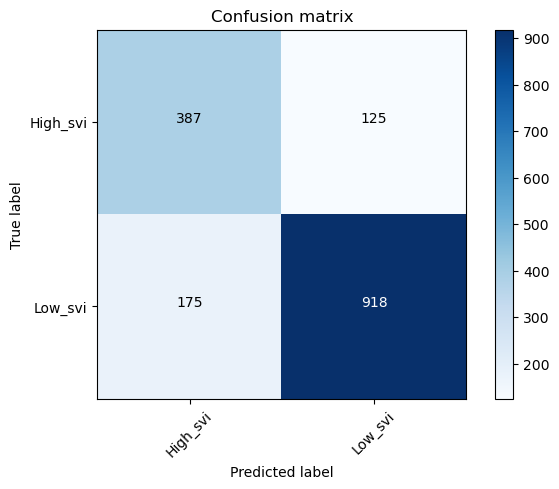

In [488]:
plot_cf_matrix(y_real, y_predict)

In [26]:
#model with resampling

In [272]:
def over_sample(X, Y, sampler):
    '''
    This function over samples data X and labels Y. Because each piece of data is 2D (hence X is 3D),
    we need to do some clever resizing since the imblearn Oversampling functions only work with a 2D X.
    '''
    
    sampler = sampler(random_state=0)

    orig_X_shape = X.shape
    X_reshaped = np.reshape(X, (X.shape[0], X.shape[1]*X.shape[2]))
    X_resampled, Y_resampled = sampler.fit_resample(X_reshaped, Y)
    X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], orig_X_shape[1], orig_X_shape[2]))
    
    return X_resampled, Y_resampled

In [309]:
X, Y = km.create_join_x_y_arr(join_list, n_steps_in=7, binary=True)
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
X_normalize = np.nan_to_num(X_normalize, nan=-1)
# X_normalize, Y_normalize = over_sample(X_normalize, Y_normalize)

100%|██████████| 7/7 [00:00<00:00, 45.69it/s]


In [489]:
# samplers = [RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE]
samplers = [SMOTE]
results_list = []
for sampler in samplers:
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
    Xtrain, ytrain = over_sample(Xtrain, ytrain, sampler)

    model = Sequential()
    model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    model.fit(Xtrain, ytrain, epochs=6, batch_size=10, shuffle=True)

    Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
    y_real = Ytest.astype(int)
    threshold = threshold_for_max_f1(y_real, Yhat)
    y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
    
    print(km.results(y_real, y_predict))
    results_list.append(km.results(y_real, y_predict))
    

Epoch 1/6
19564/19564 [==============================] - 18s 939us/step - loss: 0.5955 - binary_accuracy: 0.5879
Epoch 2/6
19564/19564 [==============================] - 17s 856us/step - loss: 0.4640 - binary_accuracy: 0.6923
Epoch 3/6
19564/19564 [==============================] - 17s 889us/step - loss: 0.4405 - binary_accuracy: 0.7297
Epoch 4/6
19564/19564 [==============================] - 17s 881us/step - loss: 0.4295 - binary_accuracy: 0.7482
Epoch 5/6
19564/19564 [==============================] - 17s 889us/step - loss: 0.4199 - binary_accuracy: 0.7590
Epoch 6/6
19564/19564 [==============================] - 17s 881us/step - loss: 0.4117 - binary_accuracy: 0.7666
(0.8249221183800624, 0.71875, 0.7287128712871287, 0.7236971484759096)


results: (0.8249221183800624, 0.71875, 0.7287128712871287, 0.7236971484759096) 

Confusion matrix, without normalization
[[368 144]
 [137 956]]


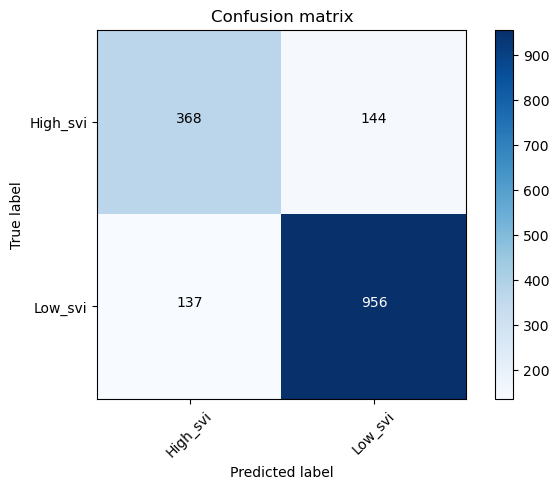

In [490]:
plot_cf_matrix(y_real, y_predict)

In [ ]:
#extra metrics

In [505]:
# fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [506]:
# auc(fpr, tpr)

0.8837595779963403

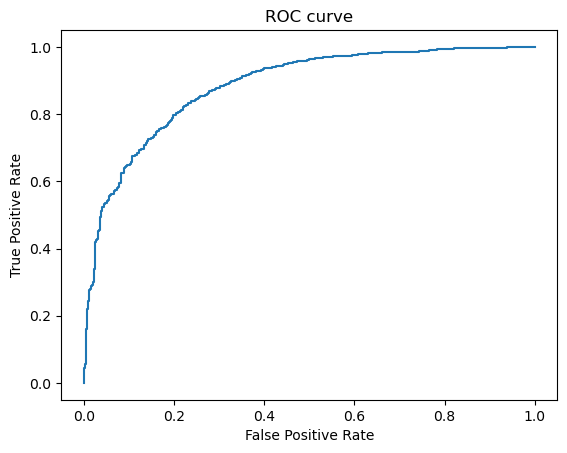

In [507]:
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# plt.show()

In [ ]:
#general model training architecture

In [136]:
model_names = {1: 'Simple LSTM',
               2: 'Stacked LSTM',
               3: 'Bidirectional LSTM',
               4: 'CNN',
               5: 'CNN LSTM',
               6: 'LSTM Autoencoder',
               7: 'Deep CNN',
               8: 'GRU',
               9: 'GRU CNN'}

def plot_graphs_metrics(model, results_list, steps_in, steps_out):
    model_name = model_names[model]
    
    #this block of code is because some models (like 6) require steps_in start at 3 instead of 1
    shift_vals = {1: 1,
                  3: 1,
                  6: 3,
                  9: 2}
    shift_val = shift_vals[model]
    
    #plot graph of a metric result for all n_step_in and n_step_out values
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(4):
        for i in range(steps_in-shift_val):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
            plt.plot(x, y, label=f'n_steps_in={i+shift_val}')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel(label[z])
        plt.title(model_name + ", 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
        plt.savefig(f"figures/{model_name} {label[z]}.png", bbox_inches="tight")
        plt.close()    
    
    #plot graph of all metric results for a n_step_in value
    x=list(range(1, steps_out))
    label = ['accuracy', 'TNR', 'NPV', 'f1']
    for z in range(steps_in-shift_val):
        for i in range(4):
            y=[]
            for j in range(steps_out-1):
                y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
            plt.plot(x, y, label=label[i])
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("n_steps_out")
        plt.ylabel('Metric value')
        plt.title(f"{model_name}, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+shift_val} ")
        plt.savefig(f"figures/{model_name} n_steps_in={z+shift_val}.png", bbox_inches="tight")
        plt.close()

In [276]:
#Model type 1
def train_SIMPLE_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in tqdm(range(1, steps_in)):
        for j in tqdm(range(1, steps_out)):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            features = Xtrain.shape[2]
            model = Sequential()
            model.add(LSTM(units=features//2, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dense(features//4, activation='relu'))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

###Just need to fill out the three functions for below. All other infrastructure is handled.###

#Model type 3
def train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(1, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
            
            features = Xtrain.shape[2]
            model = Sequential()
            model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(50, return_sequences=True, activation='relu')))
            model.add(Bidirectional(LSTM(20, activation='relu')))
            model.add(Dense(1, activation="sigmoid"))
            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

#Model type 6 - having lots of trouble with this one
#For some reason we need steps_in to be at least 3 for this one
#This probably has to do with the pooling, Convolution, or Dropout layers
def train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(3, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)

            features = Xtrain.shape[2]
            model = Sequential()
            model.add(Conv1D(filters=128, 
                             kernel_size=2, 
                             activation='relu', 
                             name='extractor', 
                             input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
            model.add(Dropout(0.3))
            model.add(MaxPooling1D(pool_size=2))
            model.add(Bidirectional(LSTM(50, activation='relu', input_shape=(Xtrain.shape[1], Xtrain.shape[2]))))
            model.add(RepeatVector(10))
            model.add(Bidirectional(LSTM(50, activation='relu')))
            model.add(Dense(1))

            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

def train_GRU_CNN_model(epochs, steps_in, steps_out):
    results_list = []
    for i in range(2, steps_in):
        for j in range(1, steps_out):
            X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out = j, binary=True)
            X_normalize, Y_normalize, scalers = km.normalize(X, Y)
            X_normalize = np.nan_to_num(X_normalize, nan=-1)
            Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)            
            
            features = Xtrain.shape[2]
            inp_seq = Input(shape=(Xtrain.shape[1], Xtrain.shape[2]))
            x = Bidirectional(GRU(100, return_sequences=True))(inp_seq)
            x = AveragePooling1D(2)(x)
            x = Conv1D(100, 3, activation='relu', padding='same',
                       name='extractor')(x)
            x = Flatten()(x)
            x = Dense(16, activation='relu')(x)
            x = Dropout(0.5)(x)

            out = Dense(1, activation="sigmoid")(x)

            model = Model(inp_seq, out)

            
            model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
            model.fit(Xtrain, ytrain, epochs=epochs, batch_size=10, shuffle=True)
            
            Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
            y_real = Ytest.astype(int)
            threshold = threshold_for_max_f1(y_real, Yhat)
            y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
            results_list.append(km.results(y_real, y_predict))
    return results_list

In [277]:
#Code to run models
list_of_result_lists = {}
models_list = [1]

epochs = 3
steps_in = 3
steps_out = 3


steps_in += 1
steps_out += 1

#will soon add a resample parameter to each model
#(default to None if no resample, otherwise uses the desired sampler)
#or use some other system for incorporating resample
for m in models_list:
    if m == 1:
        results_list = train_SIMPLE_LSTM_model(epochs, steps_in, steps_out)
    elif m == 3:
        results_list = train_BIDIRECTIONAL_LSTM_model(epochs, steps_in, steps_out)
    elif m == 6:
        results_list = train_LSTM_AUTOENCODER_model(epochs, steps_in, steps_out)
    elif m == 9:
        results_list = train_GRU_CNN_model(epochs, steps_in, steps_out)
    
    list_of_result_lists[m] = results_list
    plot_graphs_metrics(m, results_list, steps_in, steps_out)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 350.28it/s]


Epoch 1/3
12854/12854 [==============================] - 5s 427us/step - loss: 0.6436
Epoch 2/3
12854/12854 [==============================] - 4s 303us/step - loss: 0.5979
Epoch 3/3
12854/12854 [==============================] - 4s 297us/step - loss: 0.5552



 33%|███▎      | 1/3 [00:17<00:35, 17.82s/it]

100%|██████████| 1/1 [00:00<00:00, 495.84it/s]


Epoch 1/3
12851/12851 [==============================] - 6s 444us/step - loss: 0.6559
Epoch 2/3
12851/12851 [==============================] - 4s 298us/step - loss: 0.6215
Epoch 3/3
12851/12851 [==============================] - 4s 302us/step - loss: 0.6013



 67%|██████▋   | 2/3 [00:35<00:17, 17.89s/it]

100%|██████████| 1/1 [00:00<00:00, 513.63it/s]


Epoch 1/3
12848/12848 [==============================] - 5s 420us/step - loss: 0.6467
Epoch 2/3
12848/12848 [==============================] - 4s 336us/step - loss: 0.6156
Epoch 3/3
12848/12848 [==============================] - 5s 369us/step - loss: 0.5934



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 651.04it/s]


Epoch 1/3
12851/12851 [==============================] - 7s 511us/step - loss: 0.6391
Epoch 2/3
12851/12851 [==============================] - 5s 377us/step - loss: 0.5780
Epoch 3/3
12851/12851 [==============================] - 5s 379us/step - loss: 0.5064



 33%|███▎      | 1/3 [00:21<00:42, 21.09s/it]

100%|██████████| 2/2 [00:00<00:00, 527.85it/s]


Epoch 1/3
12848/12848 [==============================] - 9s 694us/step - loss: 0.6404
Epoch 2/3
12848/12848 [==============================] - 6s 463us/step - loss: 0.5914
Epoch 3/3
12848/12848 [==============================] - 5s 423us/step - loss: 0.5298



 67%|██████▋   | 2/3 [00:48<00:24, 24.69s/it]

100%|██████████| 2/2 [00:00<00:00, 601.12it/s]


Epoch 1/3
12844/12844 [==============================] - 7s 574us/step - loss: 0.6345
Epoch 2/3
12844/12844 [==============================] - 6s 451us/step - loss: 0.5846
Epoch 3/3
12844/12844 [==============================] - 6s 435us/step - loss: 0.5257



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 573.31it/s]


Epoch 1/3
12848/12848 [==============================] - 9s 703us/step - loss: 0.6197
Epoch 2/3
12848/12848 [==============================] - 7s 552us/step - loss: 0.5320
Epoch 3/3
12848/12848 [==============================] - 7s 541us/step - loss: 0.4675



 33%|███▎      | 1/3 [00:28<00:57, 28.81s/it]

100%|██████████| 3/3 [00:00<00:00, 549.95it/s]


Epoch 1/3
12844/12844 [==============================] - 11s 821us/step - loss: 0.6260
Epoch 2/3
12844/12844 [==============================] - 9s 737us/step - loss: 0.5681
Epoch 3/3
12844/12844 [==============================] - 10s 793us/step - loss: 0.5037



 67%|██████▋   | 2/3 [01:05<00:33, 33.58s/it]

100%|██████████| 3/3 [00:00<00:00, 438.86it/s]


Epoch 1/3
12841/12841 [==============================] - 14s 1ms/step - loss: 0.6353
Epoch 2/3
12841/12841 [==============================] - 10s 786us/step - loss: 0.5969
Epoch 3/3
12841/12841 [==============================] - 8s 660us/step - loss: 0.5420



100%|██████████| 3/3 [03:57<00:00, 79.01s/it]


In [ ]:
results_list

In [ ]:
list_of_result_lists

In [ ]:
# list_of_result_lists[6]